Connected to .venv (Python 3.8.10)

# Testing Gerchberg-Saxton on the photonic lantern

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from photonics.simulations.lantern_optics import LanternOptics
from photonics.simulations.optics import Optics
from hcipy import imshow_field
from photonics.utils import nanify, zernike_names
from photonics.linearity import plot_linearity
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm

optics = Optics(lantern_fnumber=6.5)
lo = LanternOptics(optics)
lo.nmodes = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Probing evaluation as a function of iteration number

This has two parts: 

a. Looking at the retrieved phase

b. Looking at the residual image

both as a function of iteration number.

Absolute differences on the PL don't show up so clearly by eye, both because the actual ports are quite small and because the intensity differences are quite slight especially for small wavefront aberrations. So we'll look at this slightly rescaled version instead:

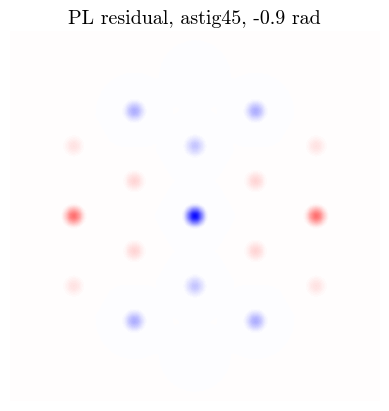

In [4]:
z, a = 4, -0.9
flat_img = np.abs(lo.plotting_lantern_output(optics.focal_propagator(optics.zernike_to_pupil(0, 0.0)))) ** 2

def pl_residual(focal_field):
    return np.abs(focal_field) ** 2 - flat_img

def show_pl_residual(focal_field, lim=np.maximum(np.max(flat_img), -np.min(flat_img)), crop=100, ax=None):
    if ax is None:
        ax = plt.gca()
    resid = pl_residual(focal_field)
    r = ax.imshow(resid[crop:-crop,crop:-crop], cmap="seismic", vmin=-lim, vmax=lim)
    ax.axis('off')
    return r
    
focal_field = lo.plotting_lantern_output(optics.focal_propagator(optics.zernike_to_pupil(z, a)))
show_pl_residual(focal_field)
plt.title(f"PL residual, {zernike_names[z]}, {a} rad");

Let's set up a Gerchberg-Saxton run where we can see the residual image and phase screen as we go.

In [5]:
def tracking_GS(z, a, niter, guess=None, restore_outside=False):
    sim_image = lo.forward(optics, optics.zernike_to_pupil(z, a)).intensity
    plotting_sim_image = np.abs(lo.plotting_lantern_output(lo.focal_propagator.forward(optics.zernike_to_pupil(z, a)))) ** 2
    result = {
        "plotting_sim_image": plotting_sim_image,
        "phase_screens": [],
        "focal_fields": [],
        "recon_zernikes": [],
    }
    for i in range(niter):
        if i == 0:
            EM_in, measuredAmplitude_in, measuredAmplitude_out = lo.GS_init(optics, sim_image, guess=guess, restore_outside=restore_outside)
        else:
            EM_in = lo.GS_iteration(optics, EM_in, measuredAmplitude_in, measuredAmplitude_out, restore_outside=restore_outside)
            
        result["phase_screens"].append(EM_in.phase)
        focal_field = lo.plotting_lantern_output(lo.focal_propagator.forward(EM_in))
        result["focal_fields"].append(focal_field)
        result["recon_zernikes"].append(optics.zernike_basis.coefficients_for(EM_in.phase)[:lo.nmodes])
        
    result["recon_zernikes"] = np.array(result["recon_zernikes"])
    return result

def tracking_GS_movie(z, a, niter=20, crop=100, guess=None, restore_outside=False):
    result = tracking_GS(z, a, niter, guess=guess)
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    im0 = axs[0].imshow(nanify(result["phase_screens"][0].shaped, optics.aperture.shaped), vmin=-np.pi/2, vmax=np.pi/2, cmap="RdBu")
    axs[0].axis('off')
    resid = pl_residual(result["focal_fields"][0])
    lim = np.maximum(np.max(resid), -np.min(resid))
    im1 = axs[1].imshow(resid, vmin=-lim, vmax=lim, cmap="seismic")
    axs[1].axis('off')
    
    def animate(t):
        fig.suptitle(f"Gerchberg-Saxton iterations, {zernike_names[z]}, {a} rad, frame {t}")
        recon_mode = result["recon_zernikes"][t][z]
        axs[0].set_title(f"Phase screen, reconstructed {zernike_names[z]} = {recon_mode:.2f} rad")
        im0.set_data(nanify(result["phase_screens"][t].shaped, optics.aperture.shaped))
        ff = result["focal_fields"][t]
        if t > 0:
            mean_change_since_last = np.mean(100 * np.abs(np.abs(ff) ** 2 / np.abs(result["focal_fields"][t-1]) ** 2 - 1))
        else:
            mean_change_since_last = 0.0
        axs[1].set_title(f"PL residual, change since last = {mean_change_since_last:.2f}%")
        im1.set_data(pl_residual(ff)[crop:-crop,crop:-crop])
    
    anim = animation.FuncAnimation(fig, animate, np.arange(len(result["phase_screens"])))
    plt.close(fig)
    return HTML(anim.to_jshtml(default_mode='loop'))

def tracking_GS_zernikes(z, a, niter=20, guess=None, restore_outside=False):
    result = tracking_GS(z, a, niter, guess=guess, restore_outside=restore_outside)
    zdecomps = result["recon_zernikes"].T
    plt.hlines(a, 0, zdecomps.shape[1] - 1, label="Target")
    for (i, r) in enumerate(zdecomps):
        if i == z:
            plt.plot(r, label="Injected mode", color="k")
        else:
            plt.plot(r, alpha=0.1, color="r")
    plt.xticks(np.arange(0, zdecomps.shape[1], 4))
    plt.xlabel("Gerchberg-Saxton iteration")
    plt.ylabel("Amplitude (rad)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplots_adjust(right=0.8)
    plt.suptitle(f"Gerchberg-Saxton iterations, {zernike_names[z]}, {a} rad")


In [6]:
tracking_GS_movie(4, -0.5, 21)

I'm not sure if I can see the "saturation" effect we're looking for here; the difference between consecutive frames is so small that it's hard to draw any conclusions.

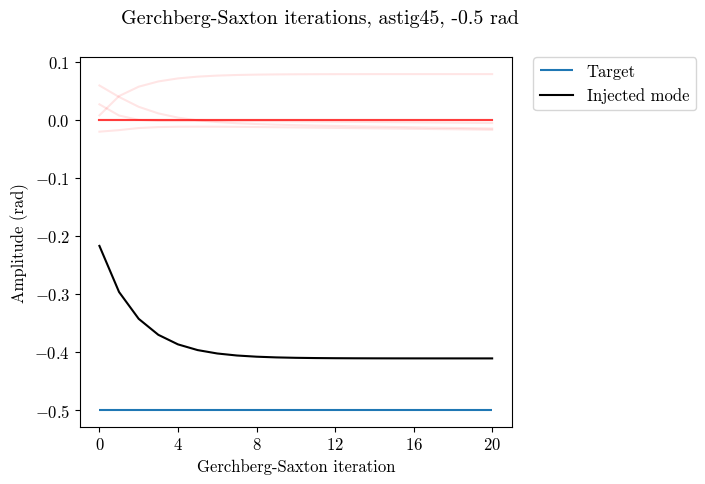

In [7]:
tracking_GS_zernikes(4, -0.5, 21)

This is consistent with what I'm seeing above -- whatever differences there are between consecutive iterations are too small to show up on the PL, so they're also too small to be interpreted as significant modal cross-talk. No matter what the injected amplitude, it seems like we systematically underestimate it (in magnitude), but we don't reconstruct anything that isn't there at least.

Now let's use the truth as the initial guess.

In [8]:
tracking_GS_movie(4, -0.5, 21, guess=optics.zernike_to_pupil(4, -0.5))

Not sure what's happening on the PL residual there, but it's staying still as we'd hope. It's not staying still at the injected mode, though.

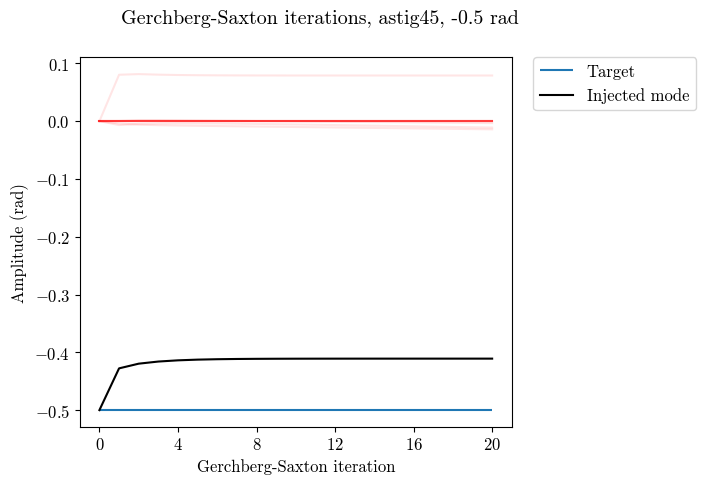

In [9]:
tracking_GS_zernikes(4, -0.5, 21, guess=optics.zernike_to_pupil(4, -0.5))

There's some sort of systematic offset -- even when we start at the correct position, we can't recognize that it's correct. This effect gets worse for higher orders, even as we lower the amplitude to compensate:

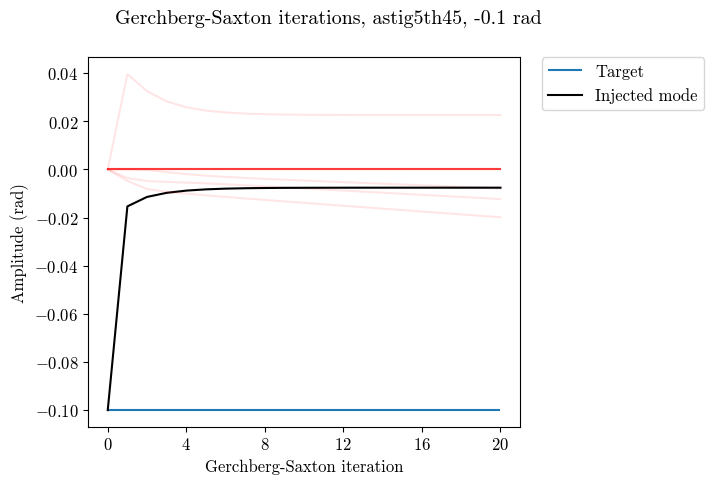

In [10]:
tracking_GS_zernikes(10, -0.1, 21, guess=optics.zernike_to_pupil(10, -0.1))

We also see modal crosstalk starting, which I think should be expected for the PL due to its inherent restriction to low orders.

The one remaining thing to try is undoing spatial filtering, where we put back the initial EM field on each G-S iteration. I'll implement this as an optional Boolean argument, `restore_outside`. Let's look at what's getting added back:

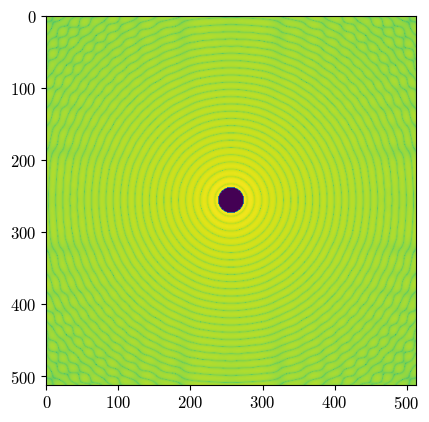

In [12]:
ref_intensity = lo.input_ref.intensity.shaped
ref_intensity *= lo.complement_mask
plt.imshow(np.log10(ref_intensity + 1e-20))

And at a lantern-to-phase backpropagation without and with this:

Text(0.5, 1.0, '+ re-filled')

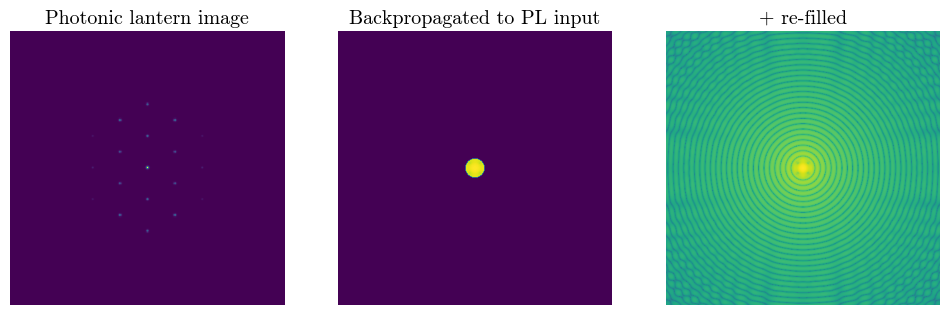

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
for ax in axs:
    ax.axis('off')
example_lantern_image = lo.forward(optics, optics.zernike_to_pupil(4, 0.5))
coeffs = lo.lantern_reverse @ example_lantern_image.electric_field
field_inside_pl_input = coeffs @ lo.outputs
imshow_field(example_lantern_image.intensity, ax=axs[0])
axs[0].set_title("Photonic lantern image")
axs[1].imshow(np.log10(np.abs(lo.input_to_2d(field_inside_pl_input, zoomed=False, restore_outside=False)) + 1e-10))
axs[1].set_title("Backpropagated to PL input")
axs[2].imshow(np.log10(np.abs(lo.input_to_2d(field_inside_pl_input, zoomed=False, restore_outside=True)) + 1e-10))
axs[2].set_title("+ re-filled")

But this doesn't seem to do anything to G-S, positive or negative.

In [14]:
tracking_GS_movie(4, -0.5, 21, restore_outside=True)

Finally, here's a linearity plot.

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [03:08<00:00, 10.46s/it]


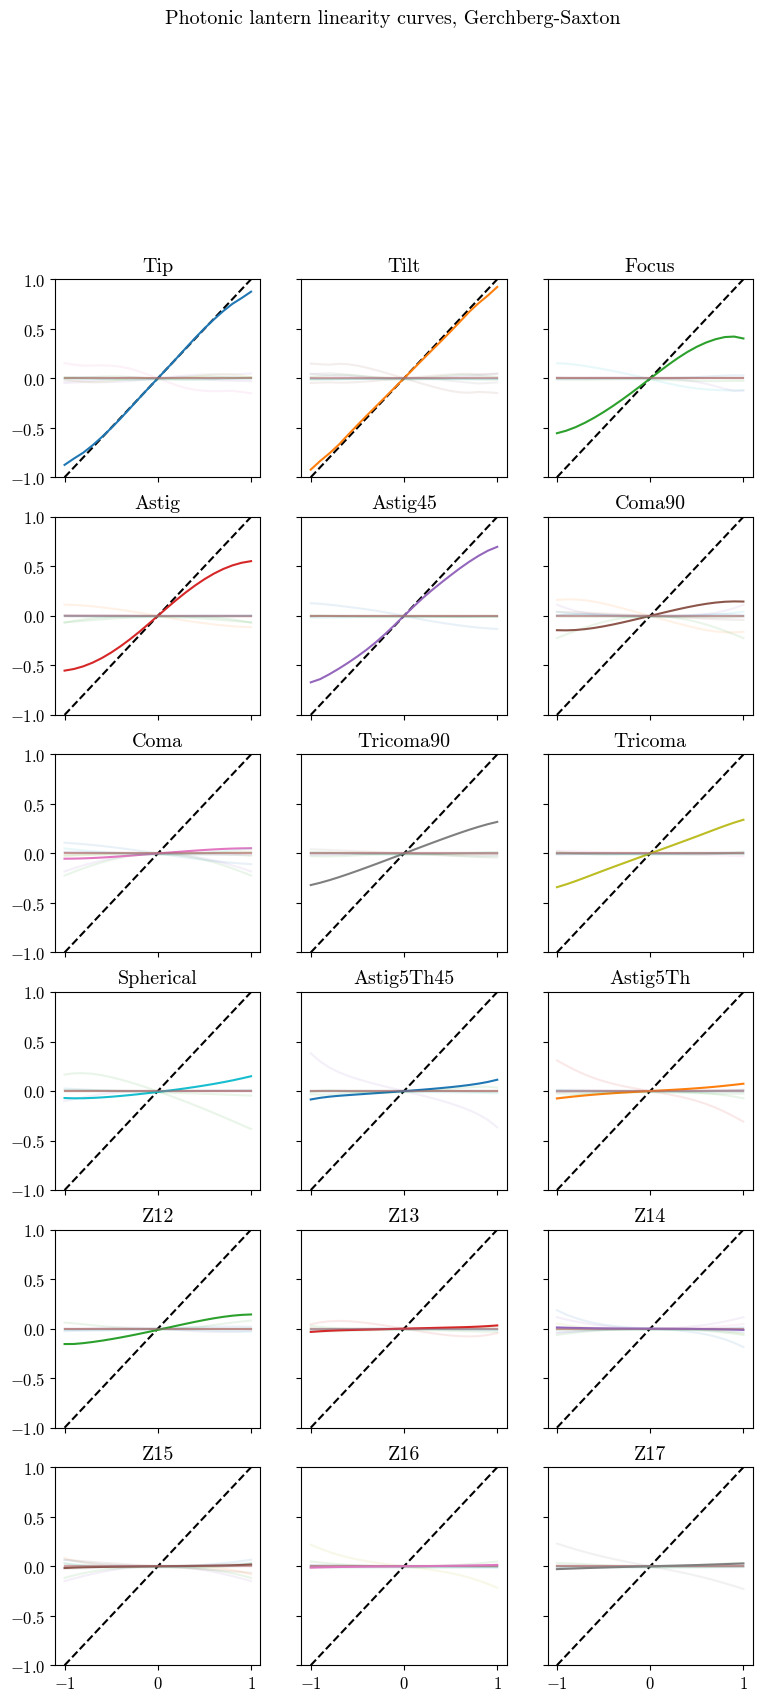

In [15]:
zr = np.arange(18)
ar = np.arange(-1.0, 1.01, 0.1)
sweep = np.zeros((len(zr), len(ar), len(zr)))
for (i, z) in enumerate(tqdm(zr)):
    # print(zernike_names[i])
    for (j, a) in enumerate(ar):
        EM_in = lo.GS(
            optics,
            lo.forward(
                optics,
                optics.zernike_to_pupil(z, a)
            ).intensity
        )
        retrieved_zernikes = optics.zernike_basis.coefficients_for(EM_in.phase)[:len(zr)]
        sweep[i,j,:] = retrieved_zernikes
        
plot_linearity(ar, sweep, "Gerchberg-Saxton")